In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from keras.models import Sequential

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os

In [ ]:
print('os.getcwd():',os.getcwd())
os.chdir('/content/drive/MyDrive')
print('os.chdir():',os.getcwd())
print(os.listdir())

os.getcwd(): /content
os.chdir(): /content/drive/MyDrive
['Colab Notebooks', 'Driver_state_classification.v1i.folder.zip']


dataset 폴더 만들기(수동)

In [ ]:
%cd /content/dataset
!unzip -qq "/content/drive/MyDrive/Driver_state_classification.v1i.folder.zip"

/content/dataset


In [ ]:
!pip install imutils

In [ ]:
from imutils import paths

In [ ]:
# 디렉토리에 있는 모든 이미지의 경로를 찾아서 그 리스트를 정렬함.
imagePaths = sorted(list(paths.list_images("/content/dataset/train")))

# random.seed(42) -> 난수 생성기의 초기값을 설정한다. 이렇게 하면 코드를 실행할 때마다 동일한 순서의 난수가 생성되어 결과의 재현서을 보장함.
# random.suffle(imagePaths) -> 이미지 경로의 리스트를 무작위로 섞는다.
random.seed(42)
random.shuffle(imagePaths)

data = []
labels = []
image_dims = (224, 224, 3) # 모든 이미지를 리사이즈할 크기를 설정함. (높이, 너비, 채널 수(RGB))

# train 파일 경로 리스트를 순회하면서,
# 각 이미지를 읽고, 설정한 크기로 리사이징한 후,
# 이미지 데이터를 벼열로 변환함.
# 그런 다음, 변환된 이미지 데이터를 data리스트에 추가함.
# 이미지의 경로를 분석하여 레이블을 추출하고, 이를 labels리스트에 추가함.
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (image_dims[1], image_dims[0]))
    image = img_to_array(image)
    data.append(image)
    l = label = imagePath.split(os.path.sep)[-2].split(" ")
    labels.append(l)

# data리스트를 Numpy배열로 변환하고 모든 픽셀 값을 0과 1 사이의 값으로 정규화함.
# labels리스트도 Numpy배열로 변환함.
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("{} images ({:.2f}MB)".format(len(imagePaths), data.nbytes / (1024 * 1000.0)))

1359 images (1598.18MB)


In [ ]:
data = np.array(data)
label = np.array(labels)
print(data.shape)

(1359, 224, 224, 3)


In [ ]:
# MultiLabelBinarizer() -> 라벨 배열을 이진 형태의 배열로 변환하는데, 이는 멀티 라벨 분류 문제에 있어서 각 라벨의 존재 여부를 0과 1로 표현하는 방식임.
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)
# total 3 labels
print("class labels:")
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i + 1, label))

class labels:
1. abnormal_state
2. drowsy_state
3. normal_state


In [ ]:
def MobileNetV2_model(learning_rate, input_shape,class_number):
    baseModel = MobileNetV2(include_top=False, input_tensor=Input(shape=input_shape)) # MobileNetV2 모델을 불러온다.
    for layer in baseModel.layers[:-3]: # [:-3]을 해야할까?
        layer.trainable = False

    model = Sequential() # Sequential 모델을 생성
    model.add(baseModel) # 위에서 생성한 MobileNetV2 모델을 첫 번째 층으로 추가함.
    model.add(AveragePooling2D(pool_size=(2, 2))) # 평균 풀링 층을 추가합니다. 이는 특성 맵의 크기를 줄이는 데 사용됨.
    model.add(Flatten()) # 특성 맵을 1차원 배열로 변환함.
    model.add(Dense(512, activation="relu")) # 512개의 뉴런을 가진 fully connected layer(Dense)를 추가하고, 활성화 함수로 ReLu를 사용함.
    model.add(Dropout(0.5)) # 과적합을 방지하기 위해 드롭 아웃 층을 추가함. 0.5는 뉴런의 50%를 무작위로 0으로 설정함.
    model.add(Dense(50, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(class_number, activation='softmax')) # 최종층으로, 클래스의 수만큼 뉴런을 가진 Dense 층을 추가하고, softmax활성화 함수를 사용하여 출력을 확률로 변환함.

    return model

In [ ]:
bs = 32
lr = 0.0001
size = (224, 224)
shape = (224,224, 3)
epochs = 10
class_number = 3

In [ ]:
model = MobileNetV2_model(lr,shape,class_number)
model.compile(loss= "categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.20)

In [ ]:
print("[INFO] training ...")
H = model.fit(trainX, trainY, batch_size=32,steps_per_epoch=len(trainX) // 32,	validation_data=(testX, testY),	validation_steps=len(testX) // 32,	epochs=20)

[INFO] training ...
Epoch 1/20
33/33 [==============================] - 13s 112ms/step - loss: 1.8174 - accuracy: 0.6127 - val_loss: 0.4332 - val_accuracy: 0.8047
Epoch 2/20
33/33 [==============================] - 3s 56ms/step - loss: 0.6864 - accuracy: 0.7962 - val_loss: 0.4836 - val_accuracy: 0.8281
Epoch 3/20
33/33 [==============================] - 2s 66ms/step - loss: 0.4153 - accuracy: 0.8607 - val_loss: 0.1894 - val_accuracy: 0.9414
Epoch 4/20
33/33 [==============================] - 2s 56ms/step - loss: 0.2523 - accuracy: 0.9109 - val_loss: 0.2689 - val_accuracy: 0.9336
Epoch 5/20
33/33 [==============================] - 2s 66ms/step - loss: 0.1687 - accuracy: 0.9469 - val_loss: 0.3253 - val_accuracy: 0.9336
Epoch 6/20
33/33 [==============================] - 2s 62ms/step - loss: 0.1399 - accuracy: 0.9564 - val_loss: 0.3740 - val_accuracy: 0.9336
Epoch 7/20
33/33 [==============================] - 2s 73ms/step - loss: 0.1493 - accuracy: 0.9555 - val_loss: 0.2127 - val_accuracy

In [ ]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=mlb.classes_))

[INFO] evaluating network...
9/9 [==============================] - 2s 155ms/step
                precision    recall  f1-score   support

abnormal_state       1.00      0.94      0.97        47
  drowsy_state       0.98      0.93      0.95        85
  normal_state       0.95      0.99      0.97       140

      accuracy                           0.96       272
     macro avg       0.97      0.95      0.96       272
  weighted avg       0.96      0.96      0.96       272



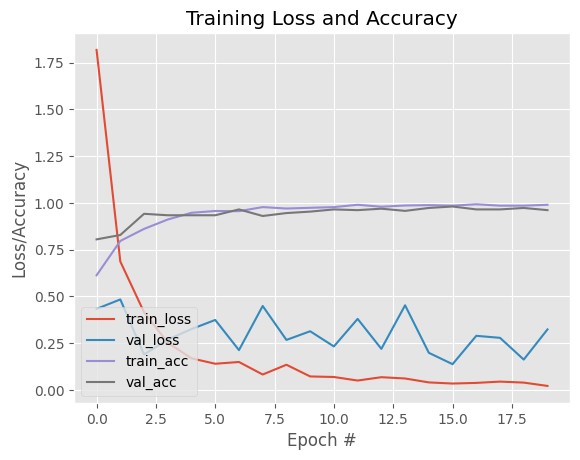

In [ ]:
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
image_path = "/content/2.png"
image = cv2.imread(image_path)
image = cv2.resize(image, (image_dims[1], image_dims[0]))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = image / 255.0  # 데이터를 [0, 1] 범위로 정규화

# 모델을 사용하여 예측
prediction = model.predict(image)
predicted_class_index = np.argmax(prediction)
predicted_class = mlb.classes_[predicted_class_index]

print(f"The predicted class is: {predicted_class}, {prediction}")

1/1 [==============================] - 1s 719ms/step
The predicted class is: drowsy_state


In [ ]:
import tensorflow as tf

mobilenet_imagenet_model = tf.keras.applications.MobileNetV2(weights="imagenet")

converter = tf.lite.TFLiteConverter.from_keras_model(mobilenet_imagenet_model)
tflite_model = converter.convert()

with open('./mobilenet_imagenet_model.tflite','wb') as f:
  f.write(tflite_model)

In [ ]:
# 모델을 TFLite 형식으로 변환

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# 변환된 모델을 파일로 저장
with open('/content/model.tflite', 'wb') as f:
  f.write(tflite_model)